# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# Define

In [2]:
def array_sign(array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(array>0) - 1.*(array<0)

def column_operate(matrix, thresh_hold = 0.001):
    rm = np.array(matrix) # reduced matrix
    fm = np.array(matrix) # filtered matrix
    ms = matrix.shape # matrix size
    mk = np.ones(matrix.shape) # mask
    pv = -1*np.ones((ms[1]), dtype = np.int) # pivots
    for t in range(ms[1]):
        fm = rm*mk # filtered matrix
        if np.abs(fm).max() < thresh_hold:
            break
        
        pr, pc = np.unravel_index(np.abs(fm).argmax(), ms) # pivot row, pivot column
        rm[:,pc] /= rm[pr][pc]
        multi = np.array(rm[pr])
        multi[pc] = 0.
        rm -= np.dot(rm[:,pc].reshape((ms[0], 1)), multi.reshape((1, ms[1])))
        mk[pr] = 0.
        mk[:,pc] = 0.
        pv[pc] = pr
    
    rm = rm[:, pv != -1]
    pv = pv[pv != -1]
    
    return rm, pv

def mcmc_normal(targets, drop_t = 10, mean=0., std=1.):
    output = np.random.normal(mean, std, targets.shape[1:])
    if drop_t>1:
        for t in range(1, drop_t):
            c = np.random.normal(mean, std, targets.shape[1:]) # candicate
            cd = np.sqrt(np.square(np.subtract(targets, c)).sum(axis=tuple(np.arange(1,len(targets.shape)))).min())
            # distance of candicate to target
            od = np.sqrt(np.square(np.subtract(targets, output)).sum(axis=tuple(np.arange(1,len(targets.shape)))).min())
            # distance of currently output to target
            if np.random.rand()*od < cd:
                output = np.array(c)
    
    return output

class VariableArray():
    def __init__(self, size, cs_initial=0.1):
        self.v = np.random.normal(0., 1., size) # array values
        self.td = np.zeros(self.v.shape) # total derivative, used to descent
        self.ltd = None # last total derivative
        self.m = np.zeros(self.v.shape) # moving array
        self.cs = cs_initial*np.ones(self.v.shape) # component-wise step
        self.work = np.ones(self.v.shape) # working components, defult to be fully connected
    
    def assign_values(self, values, cs_initial=0.1):
        self.v = np.array(values)
        self.td = np.zeros(self.v.shape)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = cs_initial*np.ones(self.v.shape)
        self.work = np.ones(self.v.shape)
    
    def derivative_assign(self, values):
        if values.shape != self.td.shape:
            raise ValueError("values shape error")
        
        self.ltd = np.array(self.td)
        self.td = np.array(values)
    
    def add_row(self, new_row, cs_initial=0.1):
        self.v = np.append(self.v, np.array([new_row]), axis = 0)
        self.td = np.append(self.td, np.zeros((1,)+new_row.shape), axis = 0)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = np.append(self.cs, cs_initial*np.ones((1,)+new_row.shape), axis = 0)
        self.work = np.ones(self.v.shape)
    
    def add_column(self, new_column, cs_initial=0.1):
        self.v = np.append(self.v, np.array([new_column]).T, axis = 1)
        self.td = np.append(self.td, np.zeros(new_column.shape + (1,)), axis = 1)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = np.append(self.cs, cs_initial*np.ones(new_column.shape + (1,)), axis = 1)
        self.work = np.ones(self.v.shape)
    
    def max_cs(self):
        return self.cs.max()
    
    def reset_cs(self, new_cs):
        self.cs = new_cs*np.ones(self.cs.shape)
    
    def descent(self, step = 1., descent_method = "normal", regularizer = ("None",), td_max = 0.1, move_max=1., move_min=0.000001):
        if regularizer[0] == "r_square":
            self.td += regularizer[1] * self.v
        
        if regularizer[0] == "rs_extend":
            self.td += regularizer[1] * ((self.v>regularizer[2])*(self.v-regularizer[2]) + (self.v < -regularizer[2])*(self.v+regularizer[2]))
        
        if descent_method == "normal":
            self.m = self.td * (np.abs(self.td) < td_max) + array_sign(self.td)*(np.abs(self.td) >= td_max)
            self.v -= step * self.m * self.work
        elif descent_method == "Rprop":
            self.m = array_sign(self.td)
            self.cs *= 1.2*(self.td*self.ltd>0) + 1.*(self.td*self.ltd==0) + 0.5*(self.td*self.ltd<0)
            self.cs = self.cs * (self.cs < move_max) * (self.cs > move_min)+ move_max*(self.cs >= move_max) + move_min*(self.cs <= move_min)
            self.v -= self.cs * self.m * self.work
        elif descent_method == "Dogiko Rprop":
            self.m = array_sign(self.td)
            step_change = 1.2*(self.td*self.ltd>0.) + 1.*(self.td*self.ltd==0.) + 1.*(self.td==self.ltd)
            step_change[step_change == 0.] = self.td[step_change == 0.]/(self.ltd-self.td)[step_change == 0.]
            step_change[step_change < 0.1] = 0.1
            self.cs *= step_change
            self.cs = self.cs * (self.cs < move_max) * (self.cs > move_min)+ move_max*(self.cs >= move_max) + move_min*(self.cs <= move_min)
            self.v -= self.cs * self.m * self.work

# Activation functions defined start

class Identity():
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.ones(x.shape, dtype = np.float64)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Sigmoid():
    def trans(self, x):
        return expit(x)
    
    def diff(self, x):
        return expit(x)*expit(-x)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Hypertan():
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        return 1. / np.square(np.cosh(x))
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Relu():
    def trans(self, x):
        return x*(x>0)
    
    def diff(self, x):
        return 1.*(x>0)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class LeakyRelu():
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def trans(self, x):
        return x*(x>0) + self.alpha*x*(x<0)
    
    def diff(self, x):
        return 1.*(x>0) + self.alpha*(x<0)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class SoftPlus():
    def trans(self, x):
        return np.log(1. + np.exp(x))
    
    def diff(self, x):
        return expit(x)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def trans(self, x):
        return self.ahpha*(x*(x>=0) + self.beta*(np.exp(x) - 1)*(x<0))
    
    def diff(self, x):
        return self.ahpha*(1.*(x>=0) + self.beta*np.exp(x)*(x<0))
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Softmax():
    def trans(self, x):
        output = x - x.max(axis=0)
        output = np.exp(output)
        output /= output.sum(axis=0)
        return output
    
    def backward(self, x, _input):
        tr = self.trans(x) # result of self.trans
        return tr*_input - tr*((tr*_input).sum(axis=0))

# Activation functions defined end

class Layer():
    def __init__(self, neuron_n, activation_function):
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        self.nn = neuron_n
        self.af = activation_function
        self.w = VariableArray((self.nn, 0)) # linear weights working before active function
        self.b = VariableArray((self.nn, 1)) # bias working before active function
        self.x = np.zeros((0, self.nn))
        self.y = np.zeros((0, self.nn))
    
    def forward(self, _input):
        self.x = np.dot(self.w.v, _input) + self.b.v
        self.y = self.af.trans(self.x)
    
    def backward(self, _input, source):
        derivative = self.af.backward(self.x, _input)
        self.w.derivative_assign(np.dot(derivative, source.T))
        self.b.derivative_assign(np.sum(derivative, axis=1).reshape(derivative.shape[0], 1))
        derivative = np.dot(derivative.T, self.w.v)
        return derivative.T
    
    def descent(self, step, descent_method, regularizer):
        self.w.descent(step, descent_method, regularizer)
        self.b.descent(step, descent_method, regularizer)
    
    def reset_cs(self, new_cs):
        self.w.reset_cs(new_cs)
        self.b.reset_cs(new_cs)
    
    def dimension(self):
        return self.w.v.size + self.b.v.size

class DogikoLearn():
    def __init__(self, loss_function = "r2"):
        self.lf = loss_function # loss function type
        self.ly = [] # layers list
        self.rg = ("None",) # Regularizetion method
        self.csi = 0.1 # initial component-wise step when claim new weights and bias
    
    def r_square_regularizer(self, alpha):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5*sum(weight**2) when descent
        if alpha <= 0:
            raise ValueError("Input should be positive")
        
        self.rg = ("r_square", alpha)
    
    def rs_extend_regularizer(self, alpha, beta):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5sum(weight**2) when descent
        if (alpha <= 0) or (alpha <= 0):
            raise ValueError("All input should be positive")
        
        self.rg = ("rs_extend", alpha, beta)
    
    def set_training_data(self, training_input, training_labels):
        self.tx = np.array(training_input) # training data input
        self.ty = np.array(training_labels) # training data lables(answers)
        if self.tx.shape[0] != self.ty.shape[0]:
            temp_min = min(self.tx.shape[0], self.ty.shape[0])
            self.tx = self.tx[:temp_min]
            self.ty = self.ty[:temp_min]
            print("training data #input != #output, took the minimun size automatically")
        
        self.xs = self.tx.shape[1] # size of each datum input
        self.ys = self.ty.shape[1] # size of each datum output
    
    def set_validating_data(self, validating_input, validating_labels):
        self.vx = np.array(validating_input) # validating data input
        self.vy = np.array(validating_labels) # validating data lables(answers)
        if self.vx.shape[1] != self.xs:
            raise ValueError("validating data input size should be equal to training data")
        
        if self.vy.shape[1] != self.ys:
            raise ValueError("validating data lables size should be equal to training data")
    
    def add_layer(self, new_layer):
        if type(new_layer) != Layer:
            raise TypeError("new_layer should be a Layer (class). eg: 'Layer(30, Sigmoid())'")

        self.ly.append(new_layer)
    
    def build(self):
        self.ln = len(self.ly) # amount of layers
        self.ly[0].w.assign_values(np.random.normal(0., 1., (self.ly[0].nn, self.xs)), self.csi)
        self.ly[0].b.assign_values(np.random.normal(0., 1., (self.ly[0].nn, 1)), self.csi)
        for l in range(1,self.ln):
            self.ly[l].w.assign_values(np.random.normal(0., 1., (self.ly[l].nn, self.ly[l-1].nn)), self.csi)
            self.ly[l].b.assign_values(np.random.normal(0., 1., (self.ly[l].nn, 1)), self.csi)
        
        if self.ly[-1].nn != self.ys: # cheak output size
            raise ValueError("output layer must has the same size with datum lables(answer)")
    
    def prediction(self, data_input):
        self.px = np.array(data_input) # prediction data input of last time predic
        if self.px.shape[1] != self.xs:
            raise ValueError("datum size error")
        
        self.ly[0].forward(self.px.T)
        for l in range(1,self.ln):
            self.ly[l].forward(self.ly[l-1].y)
        
        self.py = np.array(self.ly[-1].y.T) # prediction result of last time predict
    
    def descent(self, step = 1., descent_method = "normal"):
        for l in range(self.ln):
            self.ly[l].descent(step, descent_method, self.rg)
        
        if descent_method in ["Rprop", "Dogiko Rprop"]:
            self.max_cs = 0.
            for l in range(self.ln):
                self.max_cs = max(self.max_cs, self.ly[l].w.max_cs(), self.ly[l].b.max_cs())
    
    def batch_fit(self, batch_input, batch_labels, step = 1., descent_method = "normal"):
        self.prediction(batch_input)
        if self.lf == "r2":
            temp_derivative = 2*(self.py - batch_labels).T/(batch_labels.shape[0]*batch_labels.var(axis=0).sum())
        elif self.lf == "ce":
            temp_derivative = -1*(batch_labels/(self.py + 0.0001)).T/batch_labels.shape[0]
        else:
            raise ValueError("loss function should be 'r2' or 'ce'")
        
        for l in range(self.ln-1, 0, -1):
            temp_derivative = self.ly[l].backward(temp_derivative, self.ly[l-1].y)
        
        self.ly[0].backward(temp_derivative, batch_input.T)
        self.descent(step, descent_method)
    
    def validate(self):
        self.prediction(self.vx)
        if self.lf == "r2":
            return np.square(self.py - self.vy).mean()/self.vy.var(axis=0).mean()
        elif self.lf == "ce":
            return (-1*self.vy*np.log(self.py+0.0001)).sum(axis=1).mean()
    
    def neuron_refined(self, l, reference_data = None, info_rate = 0.01):
        # l : the no. of layer
        # info_rate : threshold for information contained of dimension be remaind
        if type(l) != int:
            raise TypeError("l should be the layer no. of hidden layer, an int between 0 to (neural_number - 2)")
        elif (l >= self.ln - 1) or (l < 0):
            raise ValueError("l should be the layer no. of hidden layer, an int between 0 to (neural_number - 2)")
        
        if type(reference_data) == type(None):
            self.prediction(self.tx)
        else:
            self.prediction(reference_data)
        
        ym = NN.ly[l].y.mean(axis=1).reshape((NN.ly[l].nn,1)) # y (output of Layer) mean of each neurons
        yn = NN.ly[l].y - ym # centralized y
        ab = np.dot(NN.ly[l+1].w.v, ym) # Adjusted bias
        ev, em = np.linalg.eigh(np.dot(yn, yn.T)) # eigenvalues and eigenmatrix(with eigenvectors as columns)
        op, pv = column_operate(em[:,ev/ev.sum() > info_rate]) # column operator result and pivots
        nw = np.dot(NN.ly[l+1].w.v, op) # new weight
        NN.ly[l+1].b.assign_values(NN.ly[l+1].b.v + (np.dot(NN.ly[l+1].w.v, ym) -np.dot(nw, ym[pv])))
        NN.ly[l+1].w.assign_values(nw) # l+1 weight should be rewrite after l+1 bias have been rewrite
        NN.ly[l].w.assign_values(NN.ly[l].w.v[pv])
        NN.ly[l].b.assign_values(NN.ly[l].b.v[pv])
        NN.ly[l].nn = len(pv)
    
    def neuron_proliferate(self, proliferating_layer, proliferating_n = 1, output_weight_bound = 1.):
        if proliferating_layer not in range(self.ln):
            raise ValueError("proliferating_layer should be an int from 0 to (#layer-1)")
            
        if type(proliferating_n) != int:
            raise ValueError("proliferating_n should be int")
        
        if proliferating_n <= 0:
            raise ValueError("proliferating_n should be postive")
            
        if out_weight_bound < 0.:
            raise ValueError("output_weight_bound should be non-negative")
            
        l = proliferating_layer
        for t in range(proliferating_n):
            NN.ly[l].w.add_row(mcmc_normal(NN.ly[l].w.v))
            NN.ly[l].b.add_row(mcmc_normal(NN.ly[l].b.v))
            NN.ly[l+1].w.add_column(output_weight_bound*(2*np.random.rand((NN.ly[l+1].nn))-1.))
            NN.ly[l].nn += 1
    
    def reset_cs(self, new_cs):
        for l in range(self.ln):
            self.ly[l].reset_cs(new_cs)
    
    def inter_layer_linear_regression(self, layer_interval):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                if ls == 0:
                    ri = np.array(self.px.T) # regression input
                else:
                    ri = np.array(self.ly[ls-1].y)
                
                ri = np.append(ri, np.ones((1, ri.shape[1])), axis=0) # append 1. for each datum as bias
                ro = np.array(self.ly[le].x)
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        rr = np.linalg.lstsq(ri.T, ro.T) # regression result (matrix, residuals, rank of ri, singuler values of ri)
        if len(rr[1]) == 0:
            raise ValueError("output data of layer" + str(ls-1) + "(= -1, for input data) should be full rank, try self.nruron_refine first")
        
        return rr[0], rr[1]/ri.shape[1]
    
    def find_linearist_layers(self, reference_data = None):
        output = (0, 0, np.inf, np.array([[]]), np.zeros((0,0)))
        
        if type(reference_data) == type(None):
            self.prediction(self.tx)
        else:
            self.prediction(reference_data)
        
        for l1 in range(NN.ln-1):
            for l2 in range(i+1, NN.ln):
                rr = NN.inter_layer_linear_regression((l1,l2))
                if np.sqrt(rr[1].sum()) < output[2]:
                    output = (l1, l2, np.sqrt(rr[1].sum()), rr[0])
        
        return output
    
    def layer_filled(self, layer_interval, weights, bias):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                pass
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        if weights.shape[0] != bias.shape[0]:
            raise ValueError("weights.shape[0] doesn't match bias.shape[0]")
        
        if weights.shape[0] != self.ly[le].nn:
            raise ValueError("weights.shape[0] doesn't match #neuron of layer at end of layer_interval")
        
        self.ly[le].w.assign_values(weights)
        self.ly[le].b.assign_values(bias)
        self.ly = self.ly[:ls] + self.ly[le:]
        self.ln = len(self.ly)
    
    def layer_filled_linear_regression(self, layer_interval):
        rr = NN.inter_layer_linear_regression(layer_interval)
        NN.layer_filled(layer_interval, rr[0].T[:,:-1], rr[0].T[:,-1:])
    
    def insert_layer(self, position, weights, bias, activation_function, next_layer_weights, next_layer_bias):
        if type(position) == int:
            if position in range(self.ln):
                pass
        else:
            raise ValueError("position should be int between 0 to self.ln")
        
        if position == 0:
            if weights.shape[1] != self.xs:
                raise ValueError("weights.shape error, cheak input and output for this new layer")
        else:
            if weights.shape[1] != self.ly[position-1].nn:
                raise ValueError("weights.shape error, cheak input and output for this new layer")
        
        if weights.shape[0] != bias.shape[0]:
            raise ValueError("weights.shape[0] doesn't match bias.shape[0]")
        
        if weights.shape[0] != next_layer_weight.shape[1]:
            raise ValueError("weights.shape[0] doesn't match next_layer_weights.shape[1]")
        
        if next_layer_weight[0] != self.ly[position+1].nn:
            raise ValueError("next_layer_weights.shape[0] match #neuron of next layer")
        
        if next_layer_bias[0] != self.ly[position+1].nn:
            raise ValueError("next_layer_bias.shape[0] match #neuron of next layer")
        
        l = position
        
        self.ly.insert(l, Layer(weight.shape[1], activation_function))
        self.ly[position].w.assign_values(weights)
        self.ly[position].b.assign_values(bias)
        self.ly[position+1].w.assign_values(next_layer_weights)
        self.ly[position+1].b.assign_values(next_layer_bias)
        
        self.ln = len(self.ly)
    
    def dimension(self):
        output = 0
        for l in range(self.ln):
            output += self.ly[l].dimension()
        
        return output

# Example 1

Fit $y = \sin{x}$

In [22]:
X = (np.arange(81)/20) - 2
X = X.reshape((81,1))
Y = np.sin(2*X)

0.00059457677337


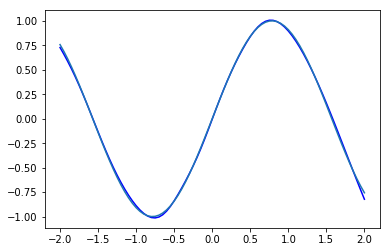

In [23]:
NN = DogikoLearn()
NN.r_square_regularizer(0.000001)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(30, Sigmoid()))
NN.add_layer(Layer(1,Identity()))
NN.build()

for i in range(10000):
    NN.batch_fit(X,Y,step=0.02, descent_method="Dogiko Rprop")
    if NN.max_cs < 0.001:
        break
        
print(NN.validate())

plt.plot(X.reshape((81)), NN.py.reshape((81)), "b", X.reshape((81)), Y.reshape((81)))
plt.show()

# Example 2

Net-shape classification

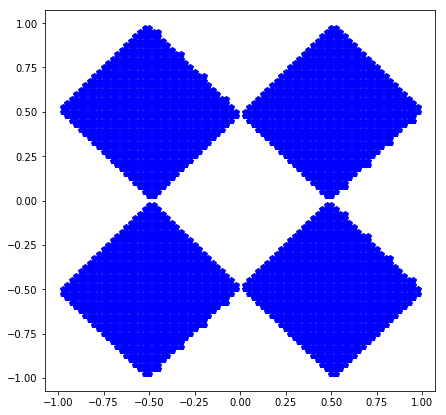

In [8]:
X = np.array([np.arange(81).repeat(81), np.arange(81*81) % 81]).astype(np.float64)
X -= 40.
X /= 40.
Y_temp = (((X[0] + X[1] - 0.5) % 2.) > 1.) ^ (((X[0] - X[1] - 0.5) % 2.) > 1.)
Y = np.zeros(Y_temp.shape + (2,))
Y[:,0] = Y_temp.astype(np.float64)
Y[:,1] = 1 - Y[:,0]
X = X.T

plt.figure(figsize=(7,7))
plt.plot(X.T[0][Y[:,0]==1], X.T[1][Y[:,0]==1], "bp")
plt.show()

In [12]:

NN = DogikoLearn(loss_function="ce")
NN.rs_extend_regularizer(0.001,3.)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(10,Selu()))
NN.add_layer(Layer(10,Selu()))
NN.add_layer(Layer(2,Softmax()))
NN.build()

for i in range(1000):
    NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
    if NN.max_cs < 0.001:
        print(i+1)
        break

print(NN.validate())

0.164631084818


8, 13, 0.124599436526
8, 14, 0.102553501933
8, 16, 0.088088761975
8, 17, 0.0850604147989
8, 17, 0.0926047268695
8, 18, 0.0775095367251
8, 16, 0.0725316662794
8, 16, 0.0771087288049
8, 15, 0.0727012654257
9, 17, 0.0764367799414
8, 17, 0.0582778755285
8, 17, 0.0587001503602
8, 17, 0.0656266296617
8, 18, 0.0537679066033
8, 18, 0.0540436130097
9, 17, 0.0537147979972
8, 19, 0.0465135592634
8, 17, 0.0448490656192
8, 17, 0.0471791676289
8, 17, 0.0501709016922


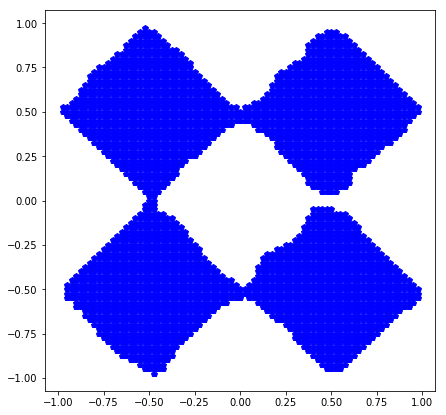

In [13]:
for t in range(20):
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, int(0.3*NN.ly[l].nn) + 1)

    for i in range(100):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.001:
            break

    for l in range(NN.ln-1):
        NN.neuron_refined(l, X,((NN.dimension()/(81*81))**2)/(NN.ly[l].nn))
        print(NN.ly[l].nn, end=", ")

    for i in range(900):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.001:
            break

    print(NN.validate())

plt.figure(figsize=(7,7))
plt.plot(X.T[0][NN.py[:,0]>0.5], X.T[1][NN.py[:,0]>0.5], "bp")
plt.show()

In [108]:
accuracys = np.zeros((100))
for t in range(100):
    NN = DogikoLearn(loss_function="ce")
    NN.rs_extend_regularizer(0.001,3.)
    NN.set_training_data(X, Y)
    NN.set_validating_data(X, Y)
    NN.add_layer(Layer(4,SoftPlus()))
    NN.add_layer(Layer(6,SoftPlus()))
    NN.add_layer(Layer(2,Softmax()))
    NN.build()
    
    for i in range(1000):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.001:
            break
    
    accuracys[t] = NN.validate()
    
    if (t+1) % 5 ==0:
        print(t+1)

print("done")

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
done


In [109]:
accuracys.sort()
print(accuracys)

[ 0.14930836  0.17467694  0.19900208  0.21985051  0.25065015  0.25105394
  0.25289252  0.2664635   0.28947304  0.30849207  0.3144399   0.32292996
  0.32312968  0.34671164  0.34853487  0.35412738  0.35920864  0.36062922
  0.36377411  0.37348301  0.38107779  0.38125456  0.38377133  0.38537388
  0.38989464  0.39140628  0.39501494  0.39583736  0.39751146  0.40065041
  0.40121617  0.40137476  0.40462831  0.41346113  0.41372077  0.41372866
  0.42869355  0.43269919  0.4469029   0.44861758  0.45601021  0.45821111
  0.46038774  0.46891753  0.4721826   0.47857811  0.47907878  0.49053982
  0.49192032  0.49327751  0.49391446  0.49419872  0.49421418  0.49582038
  0.49594001  0.49637126  0.49775038  0.49809237  0.50781834  0.50798085
  0.5088802   0.50929631  0.50965702  0.5098406   0.51007673  0.51010757
  0.51012748  0.51016921  0.51020141  0.51027329  0.51030911  0.51031036
  0.51043136  0.51048715  0.51051121  0.51051849  0.51053353  0.5105704
  0.51065559  0.51080214  0.51081957  0.51121902  0.

In [427]:
for i in range(1000):
    NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
    if NN.max_cs < 0.005:
        print(i+1)
        break
    
    if (i+1) % 100 == 0:
        print(NN.max_cs, NN.validate())

print(NN.validate())

NN.prediction(X)
for l in range(NN.ln-1):
    print(NN.ly[l].nn, end= ", ")
    NN.neuron_refined(l, 0.0001)
    print(NN.ly[l].nn)

print(NN.validate())

0.0298054745629 0.184964344596
0.0255849498409 0.107168698878
0.150720029395 0.0752482418403
0.0162777631746 0.0585776169849
0.00942000183717 0.0448976070998
525
0.0428770005388
11, 11
14, 14
7, 7
8, 8
8, 8
0.0428770005388


In [428]:
for i in range(NN.ln-1):
    for j in range(i+1, NN.ln):
        rr = NN.inter_layer_linear_regression((i,j))
        print(i, j, rr[0].shape, (rr[1].sum()/(NN.ly[j].x.var(axis=1).sum()+0.01)))

0 1 (3, 14) 0.130444846972
0 2 (3, 7) 0.231528073004
0 3 (3, 8) 0.317228603247
0 4 (3, 8) 0.382807755631
0 5 (3, 2) 0.863308064053
1 2 (12, 7) 0.0187807466046
1 3 (12, 8) 0.0245628789634
1 4 (12, 8) 0.0639242763452
1 5 (12, 2) 0.463540503118
2 3 (15, 8) 0.0051484448974
2 4 (15, 8) 0.0277319356708
2 5 (15, 2) 0.192855493295
3 4 (8, 8) 0.0486170977643
3 5 (8, 2) 0.282291072423
4 5 (9, 2) 0.0897404514687


# Examlple 3
Linear case 

In [12]:
X = np.random.normal(0,1, (10000, 5))

In [13]:
A = np.random.normal(0,1, (5,5))
while np.linalg.det(A) < 0.5:
    A = np.random.normal(0,1, (5,5))

In [14]:
Y = np.dot(X,A)

In [15]:
NN = DogikoLearn(loss_function="r2")
NN.rs_extend_regularizer(0.001,10.)
NN.set_training_data(X, Y)
NN.set_validating_data(X, Y)
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(5,Identity()))
NN.build()

In [16]:
for t in range(20):
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, int(0.1*NN.ly[l].nn) + 1)

    for i in range(100):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.0001:
            break

    for l in range(NN.ln-1):
        NN.neuron_refined(l, X,((NN.dimension()/(10000))**2)/(NN.ly[l].nn))
        print(NN.ly[l].nn, end=", ")

    for i in range(100):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.0001:
            break

    print(NN.validate())

9, 12, 27, 0.0493435386694
9, 9, 12, 0.0113445106801
10, 8, 12, 0.00755824874162
10, 8, 10, 0.00444346400938
10, 9, 10, 0.00263462290757
12, 9, 10, 0.000664910727598
9, 8, 8, 0.00237638763757
8, 8, 7, 0.00076685471248
7, 8, 7, 0.00224576035833
7, 8, 8, 0.00104895855289
7, 7, 7, 0.00155323345726
8, 7, 7, 0.000591984296887
7, 7, 6, 8.92301498747e-05
6, 7, 7, 0.00106030334232
7, 8, 7, 0.000243928801053
7, 8, 7, 0.000579466981622
7, 6, 6, 0.00053306100836
6, 6, 6, 0.00145979593393
6, 7, 6, 0.000504371044989
7, 7, 6, 0.000187245110848


In [64]:
for i in range(100):
    NN.batch_fit(X,Y,step=0.5, descent_method="Rprop")

In [65]:
for l in range(NN.ln-1):
    print(NN.ly[l].nn, end= ", ")
    NN.neuron_refined(l, None, 0.0001)
    print(NN.ly[l].nn)

10, 10


In [18]:
for i in range(NN.ln-1):
    for j in range(i+1, NN.ln):
        rr = NN.inter_layer_linear_regression((i,j))
        print(i, j, np.sqrt(rr[1].sum()))

0 1 1.97488787516
0 2 0.198389442508
0 3 0.0773856446697
1 2 0.0856913391978
1 3 0.0664770708499
2 3 0.0453495495103


In [19]:
NN.find_linearist_layers()

(2,
 3,
 0.045349549510285449,
 array([[  7.37909068e-01,   1.36688644e+00,   1.18875907e-01,
           1.60823710e+00,   2.32334058e+00],
        [ -1.99027809e+00,   7.95704616e-02,   2.33375503e+00,
           1.30950831e+00,  -2.09308503e+00],
        [  1.00995472e+00,  -1.26908820e+00,  -2.03313348e+00,
          -7.55867362e-01,   1.49329954e+00],
        [  3.09557065e+00,  -8.96893147e-01,   2.60833176e+00,
          -1.70121564e+00,   1.18876746e+00],
        [ -3.72156715e-01,   3.86547542e-01,   1.66788412e-01,
          -2.18299093e-01,  -8.32671074e-03],
        [  7.32273994e-01,   3.75661288e-01,  -2.09217312e+00,
           2.58633725e+00,   4.62945519e+00],
        [  1.76109532e-01,   4.28704448e-01,   2.01013030e-01,
           2.37578092e-01,   4.44451492e-02],
        [ -5.70100774e+00,   4.97853259e+00,  -8.63536907e+00,
          -2.95521104e+00,  -9.00040900e+00]]))